<a href="https://colab.research.google.com/github/mhmmdmin/Portfolio/blob/main/A_B_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install and Load Packages

In [1]:
!pip install dython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.power import TTestPower, TTestIndPower, GofChisquarePower
from statsmodels.stats.proportion import proportions_chisquare
from statsmodels.stats.weightstats import ttest_ind

import statsmodels.api as sm
import scipy.stats as ss
from scipy.stats import chi2_contingency

from dython.nominal import associations

#Load Dataset

In [3]:
raw_data = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/marketing_campaign_experiment/marketing-clean.csv")

#Data Inspection

In [4]:
# Check 1st five rows
raw_data.head()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained,conversion
0,a100000040,1/1/18,House Ads,personalization,True,English,English,19-24 years,1/1/18,1/18/18,House Ads,False,1
1,a100000041,1/1/18,House Ads,personalization,True,Arabic,Arabic,24-30 years,1/1/18,2/22/18,House Ads,False,1
2,a100000042,1/1/18,House Ads,personalization,True,English,English,0-18 years,1/1/18,3/9/18,House Ads,False,1
3,a100000043,1/1/18,House Ads,personalization,True,English,English,19-24 years,1/1/18,2/18/18,House Ads,False,1
4,a100000044,1/1/18,House Ads,personalization,True,Arabic,Arabic,24-30 years,1/1/18,3/3/18,House Ads,False,1


In [5]:
# Check data structure
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577 entries, 0 to 576
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              577 non-null    object
 1   date_served          577 non-null    object
 2   marketing_channel    577 non-null    object
 3   variant              577 non-null    object
 4   converted            577 non-null    bool  
 5   language_displayed   577 non-null    object
 6   language_preferred   577 non-null    object
 7   age_group            577 non-null    object
 8   date_subscribed      577 non-null    object
 9   date_canceled        577 non-null    object
 10  subscribing_channel  577 non-null    object
 11  is_retained          577 non-null    bool  
 12  conversion           577 non-null    int64 
dtypes: bool(2), int64(1), object(10)
memory usage: 50.8+ KB


There are 577 rows and 13 columns for this dataset. But there are some data types which are required to be changed.

**Change Date Type**

In [6]:
# Change data type
raw_data['date_served'] = pd.to_datetime(raw_data['date_served'])
raw_data['date_subscribed'] = pd.to_datetime(raw_data['date_subscribed'])
raw_data['date_canceled'] = pd.to_datetime(raw_data['date_canceled'])

In [7]:
# Check data structure again
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577 entries, 0 to 576
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              577 non-null    object        
 1   date_served          577 non-null    datetime64[ns]
 2   marketing_channel    577 non-null    object        
 3   variant              577 non-null    object        
 4   converted            577 non-null    bool          
 5   language_displayed   577 non-null    object        
 6   language_preferred   577 non-null    object        
 7   age_group            577 non-null    object        
 8   date_subscribed      577 non-null    datetime64[ns]
 9   date_canceled        577 non-null    datetime64[ns]
 10  subscribing_channel  577 non-null    object        
 11  is_retained          577 non-null    bool          
 12  conversion           577 non-null    int64         
dtypes: bool(2), datetime64[ns](3), int6

**Check Unique Value**

In [8]:
# Check unique value
for x in raw_data.columns:
  print(f"unique of {x} ")
  print(f"{raw_data[x].unique()}")
  print()

unique of user_id 
['a100000040' 'a100000041' 'a100000042' 'a100000043' 'a100000044'
 'a100000045' 'a100000046' 'a100000047' 'a100000048' 'a100000059'
 'a100000060' 'a100000061' 'a100000062' 'a100000063' 'a100000064'
 'a100000065' 'a100000066' 'a100000067' 'a100000088' 'a100000089'
 'a100000090' 'a100000091' 'a100000092' 'a100000093' 'a100000094'
 'a100000095' 'a100000096' 'a100000101' 'a100000102' 'a100000103'
 'a100000104' 'a100000105' 'a100000107' 'a100000108' 'a100000109'
 'a100000110' 'a100000164' 'a100000165' 'a100000166' 'a100000167'
 'a100000168' 'a100000169' 'a100000170' 'a100000171' 'a100000172'
 'a100000260' 'a100000261' 'a100000262' 'a100000263' 'a100000264'
 'a100000265' 'a100000266' 'a100000267' 'a100000268' 'a100000294'
 'a100000295' 'a100000296' 'a100000297' 'a100000298' 'a100000299'
 'a100000300' 'a100000301' 'a100000302' 'a100000317' 'a100000318'
 'a100000319' 'a100000320' 'a100000321' 'a100000322' 'a100000323'
 'a100000324' 'a100000325' 'a100000337' 'a100000338' 'a10

From the information above we know that the campaign was only held for 1 month which is in December 2017 - January 2018, and mostly the customers subscribed on the same month. Then, all customers churn which we can see from `is_retained` feature that has only 1 value, False.

**Check converted column and conversion column**

In [9]:
# Check converted with conversion
raw_data[(raw_data['converted'] == True) & (raw_data['conversion'] == 0)]

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained,conversion


In [10]:
raw_data[(raw_data['converted'] == False) & (raw_data['conversion'] == 1)]

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained,conversion


It seems that converted and conversion has the same value which if the converted is True, the conversion will be 1 and vice versa.

In [11]:
#Check missing value
raw_data.isnull().sum()

user_id                0
date_served            0
marketing_channel      0
variant                0
converted              0
language_displayed     0
language_preferred     0
age_group              0
date_subscribed        0
date_canceled          0
subscribing_channel    0
is_retained            0
conversion             0
dtype: int64

In [12]:
#Check data duplicated
raw_data.duplicated().sum()

2

In [13]:
raw_data[raw_data.duplicated(keep=False)]

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained,conversion
309,a100000889,2018-01-03,House Ads,control,False,English,English,45-55 years,2018-01-03,2018-03-24,Email,False,0
311,a100000889,2018-01-03,House Ads,control,False,English,English,45-55 years,2018-01-03,2018-03-24,Email,False,0
334,a100000894,2018-01-03,House Ads,control,False,English,English,30-36 years,2018-01-08,2018-04-02,Instagram,False,0
336,a100000894,2018-01-03,House Ads,control,False,English,English,30-36 years,2018-01-08,2018-04-02,Instagram,False,0


In [14]:
#Drop duplicates
raw_data.drop_duplicates(inplace=True, ignore_index=True)

#Data Exploration

In [15]:
#Define function for visualization
def prop_agg(df, y, x):
  temp_df = df.groupby([y,x], as_index = False).size()
  temp_df['prop'] = temp_df['size'] / temp_df.groupby(y)['size'].transform('sum')
  return temp_df

##Total User per Marketing Channel

In [23]:
colors = ["#1DB954", "#14863c", "#0c341c", "#0c5d2b"]
customPalette = sns.set_palette(sns.color_palette(colors))

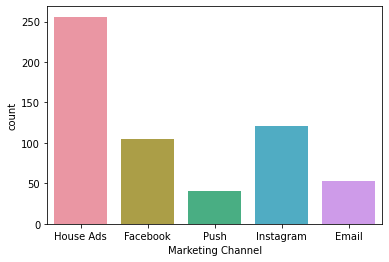

In [29]:
sns.countplot(x = 'marketing_channel', data = raw_data, palette = customPalette)
plt.xlabel("Marketing Channel");

<AxesSubplot:>

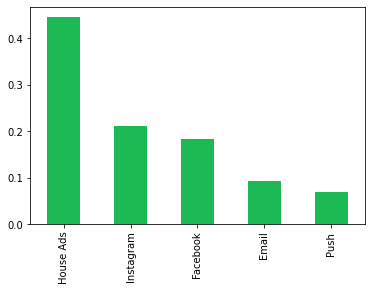

In [22]:
raw_data['marketing_channel'].value_counts(normalize = True).plot(kind='bar')

House Ads is the most used marketing channel with **44.5%** (256 customers). Followed by Instagram with **21%** (121 customers). Then, Facebook with **18.2%** (105 customers). The last two are Email and Push Notification with **9.2%** (53 customers) and **6.9%** (40 customers). 

##Total User per Variant

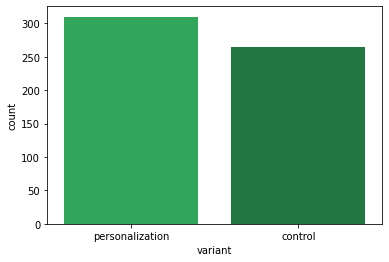

In [28]:
sns.countplot(x = 'variant', data = raw_data, palette = customPalette);

<AxesSubplot:>

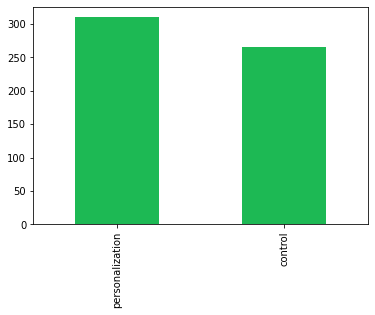

In [31]:
raw_data['variant'].value_counts().plot(kind = 'bar')

From the visualization we know that the data has difference around 7% (45 users) between variant and control group. But it's not too significant so we can accept that.

## Total User Converted per Variant##

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


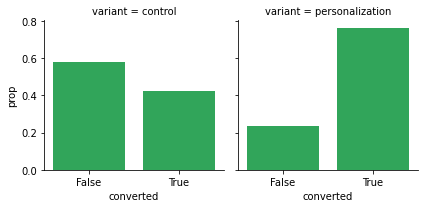

In [32]:
g = sns.FacetGrid(
    data = prop_agg(raw_data, "variant", "converted"),
    col = "variant"
)
g.map(sns.barplot, "converted", "prop");

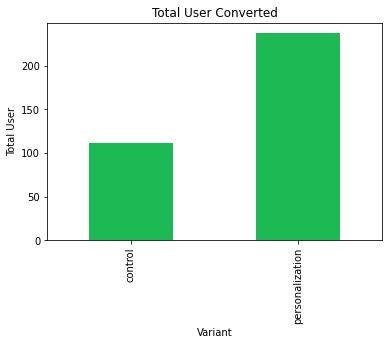

In [34]:
(raw_data.groupby('variant')['conversion'].sum()).plot(kind='bar')
plt.title('Total User Converted')
plt.ylabel('Total User')
plt.xlabel('Variant');

The conversion rate between control and personalization from the plot above seems significant. The conversion rate for personalization group almost **80%** (around 237 users) from its population and control group only **42%** (roughly 112 users) from its population. From this plot, we also know that the treatment is seemed having an impact on conversion.

##Total User Converted per Variant from Time to Time

In [35]:
#Create week based column
raw_data['week_subscribed'] = raw_data['date_subscribed'].dt.isocalendar().week

raw_data.head()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained,conversion,week_subscribed
0,a100000040,2018-01-01,House Ads,personalization,True,English,English,19-24 years,2018-01-01,2018-01-18,House Ads,False,1,1
1,a100000041,2018-01-01,House Ads,personalization,True,Arabic,Arabic,24-30 years,2018-01-01,2018-02-22,House Ads,False,1,1
2,a100000042,2018-01-01,House Ads,personalization,True,English,English,0-18 years,2018-01-01,2018-03-09,House Ads,False,1,1
3,a100000043,2018-01-01,House Ads,personalization,True,English,English,19-24 years,2018-01-01,2018-02-18,House Ads,False,1,1
4,a100000044,2018-01-01,House Ads,personalization,True,Arabic,Arabic,24-30 years,2018-01-01,2018-03-03,House Ads,False,1,1


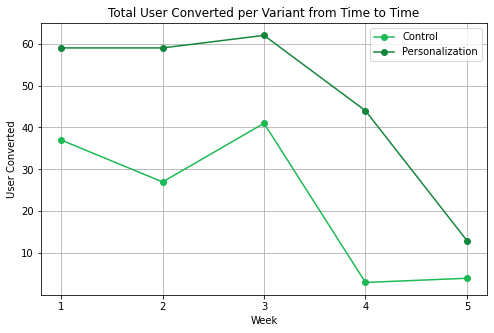

In [36]:
pd.pivot_table(raw_data,index="week_subscribed",columns="variant",values="conversion",
               aggfunc='sum').plot(figsize=(8,5), marker='o')

plt.title('Total User Converted per Variant from Time to Time')
plt.ylabel('User Converted')
plt.xlabel('Week')
plt.legend(['Control','Personalization'], loc = 0)
plt.xticks([1,2,3,4,5])
plt.grid(True);

**Total user converted seems to decrease time to time for both control and treated variant.**

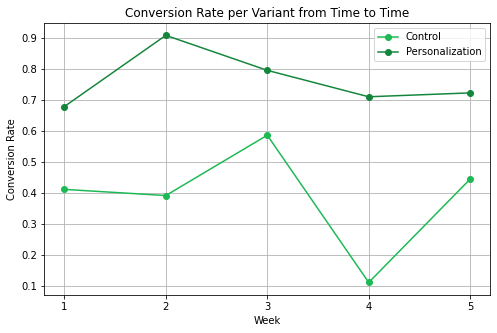

In [37]:
pd.pivot_table(raw_data,index="week_subscribed",columns="variant",values="conversion",
               aggfunc='mean').plot(figsize=(8,5), marker='o')

plt.title('Conversion Rate per Variant from Time to Time')
plt.ylabel('Conversion Rate')
plt.xlabel('Week')
plt.legend(['Control','Personalization'], loc = 0)
plt.xticks([1,2,3,4,5])
plt.grid(True);

**But during the experimental period, it can be concluded from the graph above that treated variant seems to have an uptrend on the second week until 90% and then the trend is going down till the fourth week reach 70% conversion rate. After that the trend is stagnant. For control variant, it seems fluctuative.**

##Total User Converted per Age Group

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


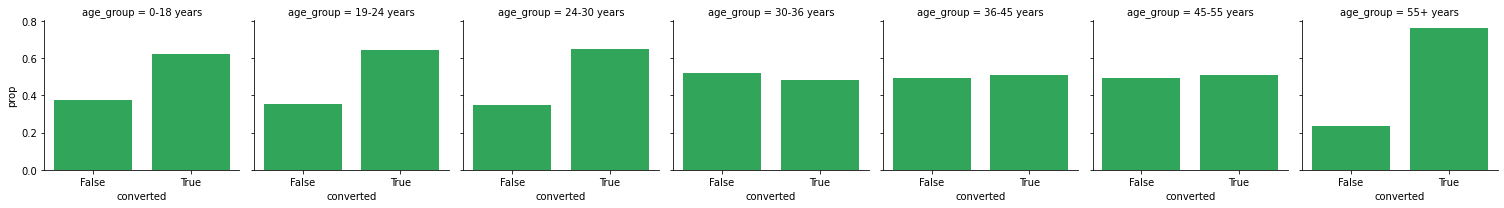

In [38]:
g = sns.FacetGrid(
    data = prop_agg(raw_data, "age_group", "converted"),
    col = "age_group"
)
g.map(sns.barplot, "converted", "prop");

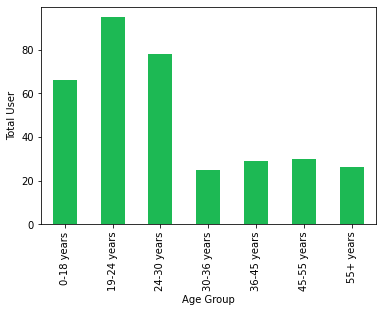

In [39]:
(raw_data.groupby('age_group')['conversion'].sum()).plot(kind = 'bar')
plt.ylabel('Total User')
plt.xlabel('Age Group');

In [40]:
raw_data.groupby('age_group')['conversion'].sum()

age_group
0-18 years     66
19-24 years    95
24-30 years    78
30-36 years    25
36-45 years    29
45-55 years    30
55+ years      26
Name: conversion, dtype: int64

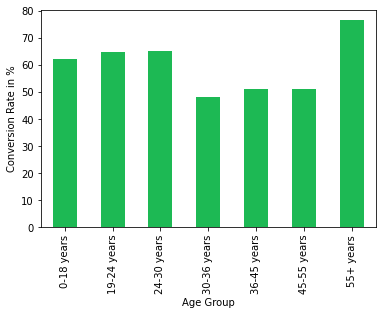

In [41]:
(raw_data.groupby('age_group')['conversion'].mean()*100).plot(kind = 'bar')
plt.ylabel('Conversion Rate in %')
plt.xlabel('Age Group');

Age group 55+ years has the most conversion rate which is almost 80% even though it has the smallest number of total user (around 26 users converted). Followed by 24-30 years (78 users converted), 19-24 years (95 users converted), and 0-18 years (66 users converted) with conversion rate around 62-65%.

##Correlation between Preferred Language and Conversion

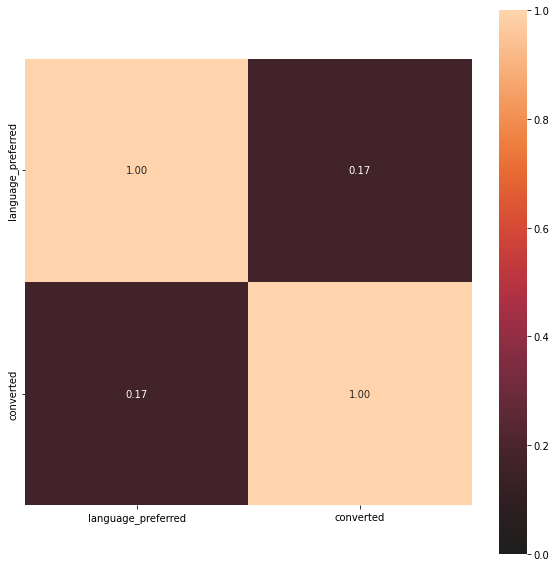

In [42]:
selected_col = raw_data[['language_preferred', 'converted']]
corr = associations(selected_col, filename= 'language_correlation.png', figsize=(10,10))

I am using associations function from dyhton package to find out the correlation between language preferred and conversion. And the result is:

**The correlation between language preferred and conversion seems too weak which is only 17%.**

#Proportion Test (Chi-Square)

In [43]:
conv_calculation = raw_data.groupby(
    ['variant', 'converted'], as_index = False
).size().pivot(
    index='variant', columns = "converted", values = "size"
).reset_index().assign(
    conv_percent = lambda x: x[True] * 100 / (x[True] + x[False])
).assign(
    total_sample = lambda x: x[True] + x[False]
)

**The Result**

In [44]:
conv_calculation

converted,variant,False,True,conv_percent,total_sample
0,control,153,112,42.264151,265
1,personalization,73,237,76.451613,310


In [45]:
conv_A = conv_calculation[conv_calculation['variant'] == 'control']['conv_percent'].values
conv_B = conv_calculation[conv_calculation['variant'] == 'personalization']['conv_percent'].values

In [46]:
print((conv_B - conv_A)*100/conv_A)

[80.88997696]


**From the descriptive value above that there are 80% uplift of B compared to A**

##Chi Square Test

In [47]:
# find number of succession
success = conv_calculation[['total_sample', True]].values[:,1]
# find number of all observations
obs = conv_calculation[['total_sample', True]].values[:,0]

In [48]:
result = proportions_chisquare(success, obs)

In [49]:
# Calculate chi squared result
print('X-squared: %.3f' % result[0])
print('p-value: %.3f' % result[1])

X-squared: 69.996
p-value: 0.000


**Interpretation**

- Variant control has 112 conversions compared to variant personalization which has 237 conversions
- Relative uplift of variant personalization (76.5% conversion rate) from variant control (42.3% conversion rate) around 80.9%
- p-value computed is 0.000 < 0.05, hence there is strong statistical significance in test results. It means that treatment had an impact on conversion rate. Then, we should reject null hypothesis and create personalization ads for all users


#Linear Models

In [54]:
# select variant and converted columns
data_for_model = raw_data[['variant', 'converted']].copy()
# create dummy variables and remove first category ('variant_control')
data_for_model = pd.get_dummies(data_for_model, drop_first = True)
# add constant
data_for_model = sm.add_constant(data_for_model)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [55]:
# check the first 5 rows
data_for_model.head()

,const,converted,variant_personalization
0,1.0,True,1
1,1.0,True,1
2,1.0,True,1
3,1.0,True,1
4,1.0,True,1


In [56]:
# define and fit logistic regression model
log_reg = sm.Logit(data_for_model['converted'], data_for_model[['variant_personalization','const']]).fit()

Optimization terminated successfully.
         Current function value: 0.608179
         Iterations 5


In [57]:
# check model summary
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:                  575
Model:                          Logit   Df Residuals:                      573
Method:                           MLE   Df Model:                            1
Date:                Thu, 11 Aug 2022   Pseudo R-squ.:                 0.09239
Time:                        15:46:54   Log-Likelihood:                -349.70
converged:                       True   LL-Null:                       -385.30
Covariance Type:            nonrobust   LLR p-value:                 3.232e-17
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
variant_personalization     1.4895      0.183      8.153      0.000       1.131       1.848
const                      -0.3119      0.124     -2.508      0.012      -0.556      -0.068
===========================================================================================
"""

**Interpretation**

- We don't have to see the Pseudo R-squ because we only focus on the effect of treatment by looking at the P-value
- We can observe uplift of variant B around 148%
- Based on p-value = 0.000 < alpha = 0.05, hence there is strong statistical significance in test results. It means the treatment ads which is personalization had a positive impact on conversion rate. Then, we should reject null hypothesis and create personalization ads for all users.


#Recommendations


---



1.   Create more personalization ads for customers especially social media and email marketing channel which aim age group 0-30 years that also has high conversion rate after age 55+ years.
2.   Increase service in order to prevent customers churn, because data tells us that all customers churn in just a few months.

